In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import torch
import pandas as pd
from tqdm import tqdm
from torchsummary import summary
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
import os
os.chdir(os.getcwd().replace('/notebooks', ''))

In [4]:
df = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
data_array = df.values
data_tensor = torch.tensor(data_array, dtype=torch.float32)

print(data_tensor.shape)

torch.Size([1460, 77])


In [5]:
features = torch.tensor(df.iloc[:, :-2].values, dtype=torch.float32)  # Tất cả cột trừ cột cuối
labels = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)  # Cột cuối cùng

print(features.shape, labels.shape)  # Kiểm tra kích thước tensor

torch.Size([1460, 75]) torch.Size([1460, 1])


In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=75):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64,32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Kích thước batch
batch_size = 32  

# Chia tập train (80%) và validation (20%)
train_size = int(0.8 * len(features))
val_size = len(features) - train_size

# Chia dataset thật thành train và validation
train_dataset, val_dataset = random_split(TensorDataset(features, labels), [train_size, val_size])

# Tạo DataLoader cho train và validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra một batch train
for batch_features, batch_labels in train_loader:
    print("Train Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

# Kiểm tra một batch validation
for batch_features, batch_labels in test_loader:
    print("Validation Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

Train Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])
Validation Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])


In [8]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    num_batches = 0  # Đếm số batch
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            num_batches += 1  # Cập nhật số batch

    # Trả về loss trung bình thay vì tổng loss
    return test_loss / num_batches if num_batches > 0 else float('inf')

In [9]:
# Khởi tạo mô hình và chuyển lên device
model = MLP()
summary(model, input_size = (75,))
model.to(device)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          19,456
       BatchNorm1d-2                  [-1, 256]             512
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
           Linear-13                    [-1, 1]              33
Total params: 63,489
Trainable params: 

In [10]:
# Danh sách lưu loss
train_losses = []
test_losses = []
batch_losses = []  # Lưu loss theo từng batch để minh họa chi tiết hơn

max_epoch = 200

# Training loop
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    batch_loss_list = []  # Lưu loss của từng batch trong epoch

    for i, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")):
        # Chuyển dữ liệu lên device
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Fix lỗi thiếu dấu ()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_loss_list.append(loss.item())  # Ghi lại loss từng batch

    # Tính trung bình loss trên tập train
    epoch_loss = running_loss / (i + 1)
    train_losses.append(epoch_loss)
    batch_losses.append(batch_loss_list)  # Ghi lại loss từng batch theo epoch

    # Đánh giá trên tập test
    model.eval()
    test_loss = evaluate(model, test_loader, criterion)
    scheduler.step(test_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{max_epoch} - Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/200: 100%|██████████| 37/37 [00:00<00:00, 111.91it/s]


Epoch 1/200 - Train Loss: 1.0057, Test Loss: 1.4161


Epoch 2/200: 100%|██████████| 37/37 [00:00<00:00, 111.00it/s]


Epoch 2/200 - Train Loss: 0.9958, Test Loss: 1.3702


Epoch 3/200: 100%|██████████| 37/37 [00:00<00:00, 126.06it/s]


Epoch 3/200 - Train Loss: 0.9481, Test Loss: 1.3037


Epoch 4/200: 100%|██████████| 37/37 [00:00<00:00, 110.45it/s]


Epoch 4/200 - Train Loss: 0.8799, Test Loss: 1.0933


Epoch 5/200: 100%|██████████| 37/37 [00:00<00:00, 139.45it/s]


Epoch 5/200 - Train Loss: 0.7216, Test Loss: 0.7772


Epoch 6/200: 100%|██████████| 37/37 [00:00<00:00, 143.63it/s]


Epoch 6/200 - Train Loss: 0.5352, Test Loss: 0.4640


Epoch 7/200: 100%|██████████| 37/37 [00:00<00:00, 116.07it/s]


Epoch 7/200 - Train Loss: 0.4098, Test Loss: 0.3461


Epoch 8/200: 100%|██████████| 37/37 [00:00<00:00, 119.82it/s]


Epoch 8/200 - Train Loss: 0.3342, Test Loss: 0.2458


Epoch 9/200: 100%|██████████| 37/37 [00:00<00:00, 138.91it/s]


Epoch 9/200 - Train Loss: 0.2851, Test Loss: 0.2409


Epoch 10/200: 100%|██████████| 37/37 [00:00<00:00, 143.58it/s]


Epoch 10/200 - Train Loss: 0.2930, Test Loss: 0.2220


Epoch 11/200: 100%|██████████| 37/37 [00:00<00:00, 119.25it/s]


Epoch 11/200 - Train Loss: 0.2781, Test Loss: 0.2080


Epoch 12/200: 100%|██████████| 37/37 [00:00<00:00, 128.58it/s]


Epoch 12/200 - Train Loss: 0.2556, Test Loss: 0.2119


Epoch 13/200: 100%|██████████| 37/37 [00:00<00:00, 106.76it/s]


Epoch 13/200 - Train Loss: 0.2579, Test Loss: 0.2036


Epoch 14/200: 100%|██████████| 37/37 [00:00<00:00, 107.49it/s]


Epoch 14/200 - Train Loss: 0.2813, Test Loss: 0.1909


Epoch 15/200: 100%|██████████| 37/37 [00:00<00:00, 131.75it/s]


Epoch 15/200 - Train Loss: 0.2390, Test Loss: 0.1910


Epoch 16/200: 100%|██████████| 37/37 [00:00<00:00, 141.10it/s]


Epoch 16/200 - Train Loss: 0.2267, Test Loss: 0.1968


Epoch 17/200: 100%|██████████| 37/37 [00:00<00:00, 140.53it/s]


Epoch 17/200 - Train Loss: 0.2601, Test Loss: 0.2251


Epoch 18/200: 100%|██████████| 37/37 [00:00<00:00, 129.03it/s]


Epoch 18/200 - Train Loss: 0.2498, Test Loss: 0.1923


Epoch 19/200: 100%|██████████| 37/37 [00:00<00:00, 128.48it/s]


Epoch 19/200 - Train Loss: 0.2705, Test Loss: 0.1931


Epoch 20/200: 100%|██████████| 37/37 [00:00<00:00, 141.81it/s]


Epoch 20/200 - Train Loss: 0.2324, Test Loss: 0.2295


Epoch 21/200: 100%|██████████| 37/37 [00:00<00:00, 140.31it/s]


Epoch 21/200 - Train Loss: 0.2407, Test Loss: 0.1786


Epoch 22/200: 100%|██████████| 37/37 [00:00<00:00, 118.91it/s]


Epoch 22/200 - Train Loss: 0.2086, Test Loss: 0.2128


Epoch 23/200: 100%|██████████| 37/37 [00:00<00:00, 121.66it/s]


Epoch 23/200 - Train Loss: 0.2277, Test Loss: 0.2363


Epoch 24/200: 100%|██████████| 37/37 [00:00<00:00, 130.50it/s]


Epoch 24/200 - Train Loss: 0.2273, Test Loss: 0.1749


Epoch 25/200: 100%|██████████| 37/37 [00:00<00:00, 139.84it/s]


Epoch 25/200 - Train Loss: 0.2238, Test Loss: 0.1981


Epoch 26/200: 100%|██████████| 37/37 [00:00<00:00, 136.78it/s]


Epoch 26/200 - Train Loss: 0.2122, Test Loss: 0.1685


Epoch 27/200: 100%|██████████| 37/37 [00:00<00:00, 124.34it/s]


Epoch 27/200 - Train Loss: 0.2266, Test Loss: 0.1849


Epoch 28/200: 100%|██████████| 37/37 [00:00<00:00, 136.50it/s]


Epoch 28/200 - Train Loss: 0.2426, Test Loss: 0.1832


Epoch 29/200: 100%|██████████| 37/37 [00:00<00:00, 122.90it/s]


Epoch 29/200 - Train Loss: 0.2156, Test Loss: 0.1816


Epoch 30/200: 100%|██████████| 37/37 [00:00<00:00, 135.60it/s]


Epoch 30/200 - Train Loss: 0.2158, Test Loss: 0.1772


Epoch 31/200: 100%|██████████| 37/37 [00:00<00:00, 118.87it/s]


Epoch 31/200 - Train Loss: 0.2157, Test Loss: 0.1776


Epoch 32/200: 100%|██████████| 37/37 [00:00<00:00, 122.10it/s]


Epoch 32/200 - Train Loss: 0.2257, Test Loss: 0.2134


Epoch 33/200: 100%|██████████| 37/37 [00:00<00:00, 102.27it/s]


Epoch 33/200 - Train Loss: 0.1999, Test Loss: 0.1959


Epoch 34/200: 100%|██████████| 37/37 [00:00<00:00, 133.97it/s]


Epoch 34/200 - Train Loss: 0.2059, Test Loss: 0.1776


Epoch 35/200: 100%|██████████| 37/37 [00:00<00:00, 126.44it/s]


Epoch 35/200 - Train Loss: 0.2309, Test Loss: 0.1808


Epoch 36/200: 100%|██████████| 37/37 [00:00<00:00, 113.09it/s]


Epoch 36/200 - Train Loss: 0.2158, Test Loss: 0.1812


Epoch 37/200: 100%|██████████| 37/37 [00:00<00:00, 131.88it/s]


Epoch 37/200 - Train Loss: 0.2213, Test Loss: 0.1670


Epoch 38/200: 100%|██████████| 37/37 [00:00<00:00, 124.51it/s]


Epoch 38/200 - Train Loss: 0.2142, Test Loss: 0.1928


Epoch 39/200: 100%|██████████| 37/37 [00:00<00:00, 123.52it/s]


Epoch 39/200 - Train Loss: 0.2184, Test Loss: 0.1753


Epoch 40/200: 100%|██████████| 37/37 [00:00<00:00, 139.30it/s]


Epoch 40/200 - Train Loss: 0.2189, Test Loss: 0.2160


Epoch 41/200: 100%|██████████| 37/37 [00:00<00:00, 129.26it/s]


Epoch 41/200 - Train Loss: 0.2101, Test Loss: 0.1710


Epoch 42/200: 100%|██████████| 37/37 [00:00<00:00, 136.00it/s]


Epoch 42/200 - Train Loss: 0.2147, Test Loss: 0.1856


Epoch 43/200: 100%|██████████| 37/37 [00:00<00:00, 103.49it/s]


Epoch 43/200 - Train Loss: 0.1805, Test Loss: 0.1870


Epoch 44/200: 100%|██████████| 37/37 [00:00<00:00, 140.82it/s]


Epoch 44/200 - Train Loss: 0.1932, Test Loss: 0.1816


Epoch 45/200: 100%|██████████| 37/37 [00:00<00:00, 115.17it/s]


Epoch 45/200 - Train Loss: 0.2402, Test Loss: 0.1832


Epoch 46/200: 100%|██████████| 37/37 [00:00<00:00, 123.60it/s]


Epoch 46/200 - Train Loss: 0.1804, Test Loss: 0.1625


Epoch 47/200: 100%|██████████| 37/37 [00:00<00:00, 129.00it/s]


Epoch 47/200 - Train Loss: 0.2074, Test Loss: 0.2155


Epoch 48/200: 100%|██████████| 37/37 [00:00<00:00, 122.15it/s]


Epoch 48/200 - Train Loss: 0.1919, Test Loss: 0.1985


Epoch 49/200: 100%|██████████| 37/37 [00:00<00:00, 127.56it/s]


Epoch 49/200 - Train Loss: 0.1944, Test Loss: 0.2156


Epoch 50/200: 100%|██████████| 37/37 [00:00<00:00, 126.53it/s]


Epoch 50/200 - Train Loss: 0.2218, Test Loss: 0.2148


Epoch 51/200: 100%|██████████| 37/37 [00:00<00:00, 139.71it/s]


Epoch 51/200 - Train Loss: 0.2055, Test Loss: 0.1836


Epoch 52/200: 100%|██████████| 37/37 [00:00<00:00, 127.22it/s]


Epoch 52/200 - Train Loss: 0.2213, Test Loss: 0.2036


Epoch 53/200: 100%|██████████| 37/37 [00:00<00:00, 135.25it/s]


Epoch 53/200 - Train Loss: 0.1932, Test Loss: 0.1874


Epoch 54/200: 100%|██████████| 37/37 [00:00<00:00, 114.57it/s]


Epoch 54/200 - Train Loss: 0.2044, Test Loss: 0.1880


Epoch 55/200: 100%|██████████| 37/37 [00:00<00:00, 133.87it/s]


Epoch 55/200 - Train Loss: 0.2115, Test Loss: 0.2003


Epoch 56/200: 100%|██████████| 37/37 [00:00<00:00, 140.02it/s]


Epoch 56/200 - Train Loss: 0.2156, Test Loss: 0.1837


Epoch 57/200: 100%|██████████| 37/37 [00:00<00:00, 138.92it/s]


Epoch 57/200 - Train Loss: 0.2103, Test Loss: 0.1746


Epoch 58/200: 100%|██████████| 37/37 [00:00<00:00, 119.19it/s]


Epoch 58/200 - Train Loss: 0.1786, Test Loss: 0.1808


Epoch 59/200: 100%|██████████| 37/37 [00:00<00:00, 130.71it/s]


Epoch 59/200 - Train Loss: 0.2076, Test Loss: 0.1922


Epoch 60/200: 100%|██████████| 37/37 [00:00<00:00, 132.31it/s]


Epoch 60/200 - Train Loss: 0.1768, Test Loss: 0.1791


Epoch 61/200: 100%|██████████| 37/37 [00:00<00:00, 137.74it/s]


Epoch 61/200 - Train Loss: 0.2181, Test Loss: 0.1857


Epoch 62/200: 100%|██████████| 37/37 [00:00<00:00, 133.96it/s]


Epoch 62/200 - Train Loss: 0.2031, Test Loss: 0.1943


Epoch 63/200: 100%|██████████| 37/37 [00:00<00:00, 126.35it/s]


Epoch 63/200 - Train Loss: 0.2264, Test Loss: 0.2134


Epoch 64/200: 100%|██████████| 37/37 [00:00<00:00, 139.90it/s]


Epoch 64/200 - Train Loss: 0.1962, Test Loss: 0.1909


Epoch 65/200: 100%|██████████| 37/37 [00:00<00:00, 113.48it/s]


Epoch 65/200 - Train Loss: 0.2316, Test Loss: 0.2138


Epoch 66/200: 100%|██████████| 37/37 [00:00<00:00, 131.45it/s]


Epoch 66/200 - Train Loss: 0.2109, Test Loss: 0.2031


Epoch 67/200: 100%|██████████| 37/37 [00:00<00:00, 119.48it/s]


Epoch 67/200 - Train Loss: 0.2102, Test Loss: 0.1732


Epoch 68/200: 100%|██████████| 37/37 [00:00<00:00, 122.28it/s]


Epoch 68/200 - Train Loss: 0.1938, Test Loss: 0.1845


Epoch 69/200: 100%|██████████| 37/37 [00:00<00:00, 142.74it/s]


Epoch 69/200 - Train Loss: 0.1920, Test Loss: 0.1732


Epoch 70/200: 100%|██████████| 37/37 [00:00<00:00, 144.30it/s]


Epoch 70/200 - Train Loss: 0.1978, Test Loss: 0.1728


Epoch 71/200: 100%|██████████| 37/37 [00:00<00:00, 147.82it/s]


Epoch 71/200 - Train Loss: 0.1857, Test Loss: 0.1912


Epoch 72/200: 100%|██████████| 37/37 [00:00<00:00, 133.10it/s]


Epoch 72/200 - Train Loss: 0.2013, Test Loss: 0.1732


Epoch 73/200: 100%|██████████| 37/37 [00:00<00:00, 139.81it/s]


Epoch 73/200 - Train Loss: 0.2034, Test Loss: 0.1995


Epoch 74/200: 100%|██████████| 37/37 [00:00<00:00, 146.90it/s]


Epoch 74/200 - Train Loss: 0.2089, Test Loss: 0.1892


Epoch 75/200: 100%|██████████| 37/37 [00:00<00:00, 145.19it/s]


Epoch 75/200 - Train Loss: 0.2021, Test Loss: 0.1824


Epoch 76/200: 100%|██████████| 37/37 [00:00<00:00, 106.19it/s]


Epoch 76/200 - Train Loss: 0.1761, Test Loss: 0.1805


Epoch 77/200: 100%|██████████| 37/37 [00:00<00:00, 120.66it/s]


Epoch 77/200 - Train Loss: 0.2183, Test Loss: 0.1929


Epoch 78/200: 100%|██████████| 37/37 [00:00<00:00, 131.61it/s]


Epoch 78/200 - Train Loss: 0.2095, Test Loss: 0.1787


Epoch 79/200: 100%|██████████| 37/37 [00:00<00:00, 123.91it/s]


Epoch 79/200 - Train Loss: 0.2056, Test Loss: 0.1997


Epoch 80/200: 100%|██████████| 37/37 [00:00<00:00, 110.58it/s]


Epoch 80/200 - Train Loss: 0.2046, Test Loss: 0.1848


Epoch 81/200: 100%|██████████| 37/37 [00:00<00:00, 131.32it/s]


Epoch 81/200 - Train Loss: 0.2265, Test Loss: 0.1803


Epoch 82/200: 100%|██████████| 37/37 [00:00<00:00, 132.57it/s]


Epoch 82/200 - Train Loss: 0.1851, Test Loss: 0.1905


Epoch 83/200: 100%|██████████| 37/37 [00:00<00:00, 114.26it/s]


Epoch 83/200 - Train Loss: 0.2088, Test Loss: 0.1959


Epoch 84/200: 100%|██████████| 37/37 [00:00<00:00, 113.79it/s]


Epoch 84/200 - Train Loss: 0.2148, Test Loss: 0.1952


Epoch 85/200: 100%|██████████| 37/37 [00:00<00:00, 129.51it/s]


Epoch 85/200 - Train Loss: 0.2045, Test Loss: 0.1720


Epoch 86/200: 100%|██████████| 37/37 [00:00<00:00, 127.23it/s]


Epoch 86/200 - Train Loss: 0.2067, Test Loss: 0.1722


Epoch 87/200: 100%|██████████| 37/37 [00:00<00:00, 102.43it/s]


Epoch 87/200 - Train Loss: 0.1912, Test Loss: 0.1713


Epoch 88/200: 100%|██████████| 37/37 [00:00<00:00, 135.66it/s]


Epoch 88/200 - Train Loss: 0.2028, Test Loss: 0.1738


Epoch 89/200: 100%|██████████| 37/37 [00:00<00:00, 119.82it/s]


Epoch 89/200 - Train Loss: 0.2113, Test Loss: 0.1756


Epoch 90/200: 100%|██████████| 37/37 [00:00<00:00, 126.28it/s]


Epoch 90/200 - Train Loss: 0.2139, Test Loss: 0.1766


Epoch 91/200: 100%|██████████| 37/37 [00:00<00:00, 118.07it/s]


Epoch 91/200 - Train Loss: 0.2086, Test Loss: 0.1789


Epoch 92/200: 100%|██████████| 37/37 [00:00<00:00, 124.69it/s]


Epoch 92/200 - Train Loss: 0.2180, Test Loss: 0.2180


Epoch 93/200: 100%|██████████| 37/37 [00:00<00:00, 134.63it/s]


Epoch 93/200 - Train Loss: 0.2042, Test Loss: 0.1937


Epoch 94/200: 100%|██████████| 37/37 [00:00<00:00, 111.98it/s]


Epoch 94/200 - Train Loss: 0.2026, Test Loss: 0.1828


Epoch 95/200: 100%|██████████| 37/37 [00:00<00:00, 130.98it/s]


Epoch 95/200 - Train Loss: 0.2147, Test Loss: 0.1929


Epoch 96/200: 100%|██████████| 37/37 [00:00<00:00, 121.00it/s]


Epoch 96/200 - Train Loss: 0.2188, Test Loss: 0.1847


Epoch 97/200: 100%|██████████| 37/37 [00:00<00:00, 105.27it/s]


Epoch 97/200 - Train Loss: 0.1925, Test Loss: 0.1887


Epoch 98/200: 100%|██████████| 37/37 [00:00<00:00, 106.63it/s]


Epoch 98/200 - Train Loss: 0.1775, Test Loss: 0.1827


Epoch 99/200: 100%|██████████| 37/37 [00:00<00:00, 122.19it/s]


Epoch 99/200 - Train Loss: 0.2070, Test Loss: 0.1855


Epoch 100/200: 100%|██████████| 37/37 [00:00<00:00, 119.60it/s]


Epoch 100/200 - Train Loss: 0.2204, Test Loss: 0.1937


Epoch 101/200: 100%|██████████| 37/37 [00:00<00:00, 120.23it/s]


Epoch 101/200 - Train Loss: 0.2345, Test Loss: 0.1977


Epoch 102/200: 100%|██████████| 37/37 [00:00<00:00, 120.36it/s]


Epoch 102/200 - Train Loss: 0.1907, Test Loss: 0.1691


Epoch 103/200: 100%|██████████| 37/37 [00:00<00:00, 112.81it/s]


Epoch 103/200 - Train Loss: 0.1870, Test Loss: 0.1838


Epoch 104/200: 100%|██████████| 37/37 [00:00<00:00, 126.87it/s]


Epoch 104/200 - Train Loss: 0.1967, Test Loss: 0.1932


Epoch 105/200: 100%|██████████| 37/37 [00:00<00:00, 119.44it/s]


Epoch 105/200 - Train Loss: 0.2044, Test Loss: 0.1971


Epoch 106/200: 100%|██████████| 37/37 [00:00<00:00, 112.43it/s]


Epoch 106/200 - Train Loss: 0.2343, Test Loss: 0.2160


Epoch 107/200: 100%|██████████| 37/37 [00:00<00:00, 100.88it/s]


Epoch 107/200 - Train Loss: 0.2161, Test Loss: 0.1688


Epoch 108/200: 100%|██████████| 37/37 [00:00<00:00, 136.42it/s]


Epoch 108/200 - Train Loss: 0.1952, Test Loss: 0.1867


Epoch 109/200: 100%|██████████| 37/37 [00:00<00:00, 124.06it/s]


Epoch 109/200 - Train Loss: 0.2211, Test Loss: 0.1802


Epoch 110/200: 100%|██████████| 37/37 [00:00<00:00, 120.88it/s]


Epoch 110/200 - Train Loss: 0.1778, Test Loss: 0.1803


Epoch 111/200: 100%|██████████| 37/37 [00:00<00:00, 123.46it/s]


Epoch 111/200 - Train Loss: 0.1961, Test Loss: 0.1792


Epoch 112/200: 100%|██████████| 37/37 [00:00<00:00, 121.40it/s]


Epoch 112/200 - Train Loss: 0.1912, Test Loss: 0.1783


Epoch 113/200: 100%|██████████| 37/37 [00:00<00:00, 119.09it/s]


Epoch 113/200 - Train Loss: 0.2197, Test Loss: 0.1742


Epoch 114/200: 100%|██████████| 37/37 [00:00<00:00, 112.51it/s]


Epoch 114/200 - Train Loss: 0.1972, Test Loss: 0.1723


Epoch 115/200: 100%|██████████| 37/37 [00:00<00:00, 131.39it/s]


Epoch 115/200 - Train Loss: 0.1830, Test Loss: 0.1856


Epoch 116/200: 100%|██████████| 37/37 [00:00<00:00, 132.98it/s]


Epoch 116/200 - Train Loss: 0.2115, Test Loss: 0.1812


Epoch 117/200: 100%|██████████| 37/37 [00:00<00:00, 113.20it/s]


Epoch 117/200 - Train Loss: 0.2076, Test Loss: 0.1959


Epoch 118/200: 100%|██████████| 37/37 [00:00<00:00, 122.61it/s]


Epoch 118/200 - Train Loss: 0.2251, Test Loss: 0.1718


Epoch 119/200: 100%|██████████| 37/37 [00:00<00:00, 116.14it/s]


Epoch 119/200 - Train Loss: 0.2263, Test Loss: 0.2026


Epoch 120/200: 100%|██████████| 37/37 [00:00<00:00, 117.82it/s]


Epoch 120/200 - Train Loss: 0.1873, Test Loss: 0.2024


Epoch 121/200: 100%|██████████| 37/37 [00:00<00:00, 125.65it/s]


Epoch 121/200 - Train Loss: 0.2206, Test Loss: 0.1855


Epoch 122/200: 100%|██████████| 37/37 [00:00<00:00, 129.13it/s]


Epoch 122/200 - Train Loss: 0.1716, Test Loss: 0.2201


Epoch 123/200: 100%|██████████| 37/37 [00:00<00:00, 118.83it/s]


Epoch 123/200 - Train Loss: 0.1824, Test Loss: 0.1887


Epoch 124/200: 100%|██████████| 37/37 [00:00<00:00, 129.59it/s]


Epoch 124/200 - Train Loss: 0.2138, Test Loss: 0.1818


Epoch 125/200: 100%|██████████| 37/37 [00:00<00:00, 126.21it/s]


Epoch 125/200 - Train Loss: 0.1914, Test Loss: 0.1791


Epoch 126/200: 100%|██████████| 37/37 [00:00<00:00, 129.36it/s]


Epoch 126/200 - Train Loss: 0.2255, Test Loss: 0.1652


Epoch 127/200: 100%|██████████| 37/37 [00:00<00:00, 115.50it/s]


Epoch 127/200 - Train Loss: 0.2197, Test Loss: 0.1780


Epoch 128/200: 100%|██████████| 37/37 [00:00<00:00, 121.37it/s]


Epoch 128/200 - Train Loss: 0.2074, Test Loss: 0.1588


Epoch 129/200: 100%|██████████| 37/37 [00:00<00:00, 121.48it/s]


Epoch 129/200 - Train Loss: 0.1914, Test Loss: 0.1816


Epoch 130/200: 100%|██████████| 37/37 [00:00<00:00, 110.50it/s]


Epoch 130/200 - Train Loss: 0.2146, Test Loss: 0.1836


Epoch 131/200: 100%|██████████| 37/37 [00:00<00:00, 107.08it/s]


Epoch 131/200 - Train Loss: 0.1975, Test Loss: 0.1892


Epoch 132/200: 100%|██████████| 37/37 [00:00<00:00, 133.91it/s]


Epoch 132/200 - Train Loss: 0.1951, Test Loss: 0.1727


Epoch 133/200: 100%|██████████| 37/37 [00:00<00:00, 125.87it/s]


Epoch 133/200 - Train Loss: 0.1933, Test Loss: 0.1943


Epoch 134/200: 100%|██████████| 37/37 [00:00<00:00, 123.70it/s]


Epoch 134/200 - Train Loss: 0.1940, Test Loss: 0.1883


Epoch 135/200: 100%|██████████| 37/37 [00:00<00:00, 139.84it/s]


Epoch 135/200 - Train Loss: 0.2124, Test Loss: 0.1982


Epoch 136/200: 100%|██████████| 37/37 [00:00<00:00, 131.06it/s]


Epoch 136/200 - Train Loss: 0.2155, Test Loss: 0.2004


Epoch 137/200: 100%|██████████| 37/37 [00:00<00:00, 115.34it/s]


Epoch 137/200 - Train Loss: 0.2260, Test Loss: 0.2049


Epoch 138/200: 100%|██████████| 37/37 [00:00<00:00, 123.52it/s]


Epoch 138/200 - Train Loss: 0.1981, Test Loss: 0.2229


Epoch 139/200: 100%|██████████| 37/37 [00:00<00:00, 125.78it/s]


Epoch 139/200 - Train Loss: 0.2211, Test Loss: 0.1715


Epoch 140/200: 100%|██████████| 37/37 [00:00<00:00, 127.79it/s]


Epoch 140/200 - Train Loss: 0.1882, Test Loss: 0.2059


Epoch 141/200: 100%|██████████| 37/37 [00:00<00:00, 113.94it/s]


Epoch 141/200 - Train Loss: 0.1913, Test Loss: 0.1829


Epoch 142/200: 100%|██████████| 37/37 [00:00<00:00, 114.71it/s]


Epoch 142/200 - Train Loss: 0.2075, Test Loss: 0.1676


Epoch 143/200: 100%|██████████| 37/37 [00:00<00:00, 93.78it/s] 


Epoch 143/200 - Train Loss: 0.2096, Test Loss: 0.1778


Epoch 144/200: 100%|██████████| 37/37 [00:00<00:00, 71.54it/s]


Epoch 144/200 - Train Loss: 0.2140, Test Loss: 0.1945


Epoch 145/200: 100%|██████████| 37/37 [00:00<00:00, 130.18it/s]


Epoch 145/200 - Train Loss: 0.2439, Test Loss: 0.1978


Epoch 146/200: 100%|██████████| 37/37 [00:00<00:00, 96.56it/s] 


Epoch 146/200 - Train Loss: 0.1948, Test Loss: 0.1796


Epoch 147/200: 100%|██████████| 37/37 [00:00<00:00, 102.08it/s]


Epoch 147/200 - Train Loss: 0.2057, Test Loss: 0.1896


Epoch 148/200: 100%|██████████| 37/37 [00:00<00:00, 93.36it/s]


Epoch 148/200 - Train Loss: 0.2089, Test Loss: 0.1786


Epoch 149/200: 100%|██████████| 37/37 [00:00<00:00, 89.64it/s]


Epoch 149/200 - Train Loss: 0.2118, Test Loss: 0.1697


Epoch 150/200: 100%|██████████| 37/37 [00:00<00:00, 82.02it/s]


Epoch 150/200 - Train Loss: 0.2186, Test Loss: 0.1992


Epoch 151/200: 100%|██████████| 37/37 [00:00<00:00, 79.41it/s]


Epoch 151/200 - Train Loss: 0.1940, Test Loss: 0.1747


Epoch 152/200: 100%|██████████| 37/37 [00:00<00:00, 88.95it/s]


Epoch 152/200 - Train Loss: 0.1939, Test Loss: 0.1867


Epoch 153/200: 100%|██████████| 37/37 [00:00<00:00, 94.97it/s]


Epoch 153/200 - Train Loss: 0.2030, Test Loss: 0.1746


Epoch 154/200: 100%|██████████| 37/37 [00:00<00:00, 107.87it/s]


Epoch 154/200 - Train Loss: 0.2090, Test Loss: 0.1750


Epoch 155/200: 100%|██████████| 37/37 [00:00<00:00, 88.26it/s]


Epoch 155/200 - Train Loss: 0.1872, Test Loss: 0.1600


Epoch 156/200: 100%|██████████| 37/37 [00:00<00:00, 71.99it/s] 


Epoch 156/200 - Train Loss: 0.2061, Test Loss: 0.1650


Epoch 157/200: 100%|██████████| 37/37 [00:00<00:00, 56.25it/s]


Epoch 157/200 - Train Loss: 0.2158, Test Loss: 0.1774


Epoch 158/200: 100%|██████████| 37/37 [00:00<00:00, 46.61it/s]


Epoch 158/200 - Train Loss: 0.2087, Test Loss: 0.1669


Epoch 159/200: 100%|██████████| 37/37 [00:00<00:00, 61.75it/s]


Epoch 159/200 - Train Loss: 0.2078, Test Loss: 0.1765


Epoch 160/200: 100%|██████████| 37/37 [00:00<00:00, 52.02it/s]


Epoch 160/200 - Train Loss: 0.1878, Test Loss: 0.1781


Epoch 161/200: 100%|██████████| 37/37 [00:00<00:00, 56.49it/s]


Epoch 161/200 - Train Loss: 0.2191, Test Loss: 0.1690


Epoch 162/200: 100%|██████████| 37/37 [00:00<00:00, 59.07it/s]


Epoch 162/200 - Train Loss: 0.1769, Test Loss: 0.1848


Epoch 163/200: 100%|██████████| 37/37 [00:00<00:00, 59.00it/s]


Epoch 163/200 - Train Loss: 0.2098, Test Loss: 0.2041


Epoch 164/200: 100%|██████████| 37/37 [00:00<00:00, 60.89it/s]


Epoch 164/200 - Train Loss: 0.2286, Test Loss: 0.2045


Epoch 165/200: 100%|██████████| 37/37 [00:00<00:00, 61.43it/s]


Epoch 165/200 - Train Loss: 0.2219, Test Loss: 0.1699


Epoch 166/200: 100%|██████████| 37/37 [00:00<00:00, 52.26it/s]


Epoch 166/200 - Train Loss: 0.1758, Test Loss: 0.2029


Epoch 167/200: 100%|██████████| 37/37 [00:00<00:00, 60.80it/s]


Epoch 167/200 - Train Loss: 0.1940, Test Loss: 0.1986


Epoch 168/200: 100%|██████████| 37/37 [00:00<00:00, 57.68it/s]


Epoch 168/200 - Train Loss: 0.2001, Test Loss: 0.2014


Epoch 169/200: 100%|██████████| 37/37 [00:00<00:00, 55.70it/s]


Epoch 169/200 - Train Loss: 0.2029, Test Loss: 0.1996


Epoch 170/200: 100%|██████████| 37/37 [00:00<00:00, 59.93it/s]


Epoch 170/200 - Train Loss: 0.2075, Test Loss: 0.1767


Epoch 171/200: 100%|██████████| 37/37 [00:00<00:00, 59.41it/s]


Epoch 171/200 - Train Loss: 0.1927, Test Loss: 0.1808


Epoch 172/200: 100%|██████████| 37/37 [00:00<00:00, 52.36it/s]


Epoch 172/200 - Train Loss: 0.1939, Test Loss: 0.1989


Epoch 173/200: 100%|██████████| 37/37 [00:00<00:00, 57.39it/s]


Epoch 173/200 - Train Loss: 0.2063, Test Loss: 0.1882


Epoch 174/200: 100%|██████████| 37/37 [00:00<00:00, 61.03it/s]


Epoch 174/200 - Train Loss: 0.2041, Test Loss: 0.1922


Epoch 175/200: 100%|██████████| 37/37 [00:00<00:00, 56.67it/s]


Epoch 175/200 - Train Loss: 0.2094, Test Loss: 0.1805


Epoch 176/200: 100%|██████████| 37/37 [00:00<00:00, 51.18it/s]


Epoch 176/200 - Train Loss: 0.2118, Test Loss: 0.1813


Epoch 177/200: 100%|██████████| 37/37 [00:00<00:00, 60.72it/s]


Epoch 177/200 - Train Loss: 0.2026, Test Loss: 0.1762


Epoch 178/200: 100%|██████████| 37/37 [00:00<00:00, 58.19it/s]


Epoch 178/200 - Train Loss: 0.2061, Test Loss: 0.1805


Epoch 179/200: 100%|██████████| 37/37 [00:00<00:00, 60.21it/s]


Epoch 179/200 - Train Loss: 0.2157, Test Loss: 0.1661


Epoch 180/200: 100%|██████████| 37/37 [00:00<00:00, 104.60it/s]


Epoch 180/200 - Train Loss: 0.1861, Test Loss: 0.1908


Epoch 181/200: 100%|██████████| 37/37 [00:00<00:00, 113.56it/s]


Epoch 181/200 - Train Loss: 0.2212, Test Loss: 0.1940


Epoch 182/200: 100%|██████████| 37/37 [00:00<00:00, 113.76it/s]


Epoch 182/200 - Train Loss: 0.2058, Test Loss: 0.1865


Epoch 183/200: 100%|██████████| 37/37 [00:00<00:00, 134.90it/s]


Epoch 183/200 - Train Loss: 0.2175, Test Loss: 0.1927


Epoch 184/200: 100%|██████████| 37/37 [00:00<00:00, 115.88it/s]


Epoch 184/200 - Train Loss: 0.2036, Test Loss: 0.1899


Epoch 185/200: 100%|██████████| 37/37 [00:00<00:00, 126.01it/s]


Epoch 185/200 - Train Loss: 0.2052, Test Loss: 0.1744


Epoch 186/200: 100%|██████████| 37/37 [00:00<00:00, 130.54it/s]


Epoch 186/200 - Train Loss: 0.1969, Test Loss: 0.1680


Epoch 187/200: 100%|██████████| 37/37 [00:00<00:00, 134.26it/s]


Epoch 187/200 - Train Loss: 0.2107, Test Loss: 0.1782


Epoch 188/200: 100%|██████████| 37/37 [00:00<00:00, 109.76it/s]


Epoch 188/200 - Train Loss: 0.2066, Test Loss: 0.1997


Epoch 189/200: 100%|██████████| 37/37 [00:00<00:00, 121.37it/s]


Epoch 189/200 - Train Loss: 0.2013, Test Loss: 0.1781


Epoch 190/200: 100%|██████████| 37/37 [00:00<00:00, 133.30it/s]


Epoch 190/200 - Train Loss: 0.2037, Test Loss: 0.1781


Epoch 191/200: 100%|██████████| 37/37 [00:00<00:00, 94.15it/s]


Epoch 191/200 - Train Loss: 0.2121, Test Loss: 0.1702


Epoch 192/200: 100%|██████████| 37/37 [00:00<00:00, 104.71it/s]


Epoch 192/200 - Train Loss: 0.1998, Test Loss: 0.1844


Epoch 193/200: 100%|██████████| 37/37 [00:00<00:00, 127.99it/s]


Epoch 193/200 - Train Loss: 0.1891, Test Loss: 0.1703


Epoch 194/200: 100%|██████████| 37/37 [00:00<00:00, 118.43it/s]


Epoch 194/200 - Train Loss: 0.1971, Test Loss: 0.1987


Epoch 195/200: 100%|██████████| 37/37 [00:00<00:00, 131.07it/s]


Epoch 195/200 - Train Loss: 0.1935, Test Loss: 0.1647


Epoch 196/200: 100%|██████████| 37/37 [00:00<00:00, 127.12it/s]


Epoch 196/200 - Train Loss: 0.2728, Test Loss: 0.2143


Epoch 197/200: 100%|██████████| 37/37 [00:00<00:00, 121.06it/s]


Epoch 197/200 - Train Loss: 0.2029, Test Loss: 0.1913


Epoch 198/200: 100%|██████████| 37/37 [00:00<00:00, 129.47it/s]


Epoch 198/200 - Train Loss: 0.1898, Test Loss: 0.1728


Epoch 199/200: 100%|██████████| 37/37 [00:00<00:00, 127.40it/s]


Epoch 199/200 - Train Loss: 0.1910, Test Loss: 0.1725


Epoch 200/200: 100%|██████████| 37/37 [00:00<00:00, 132.96it/s]


Epoch 200/200 - Train Loss: 0.2270, Test Loss: 0.1731


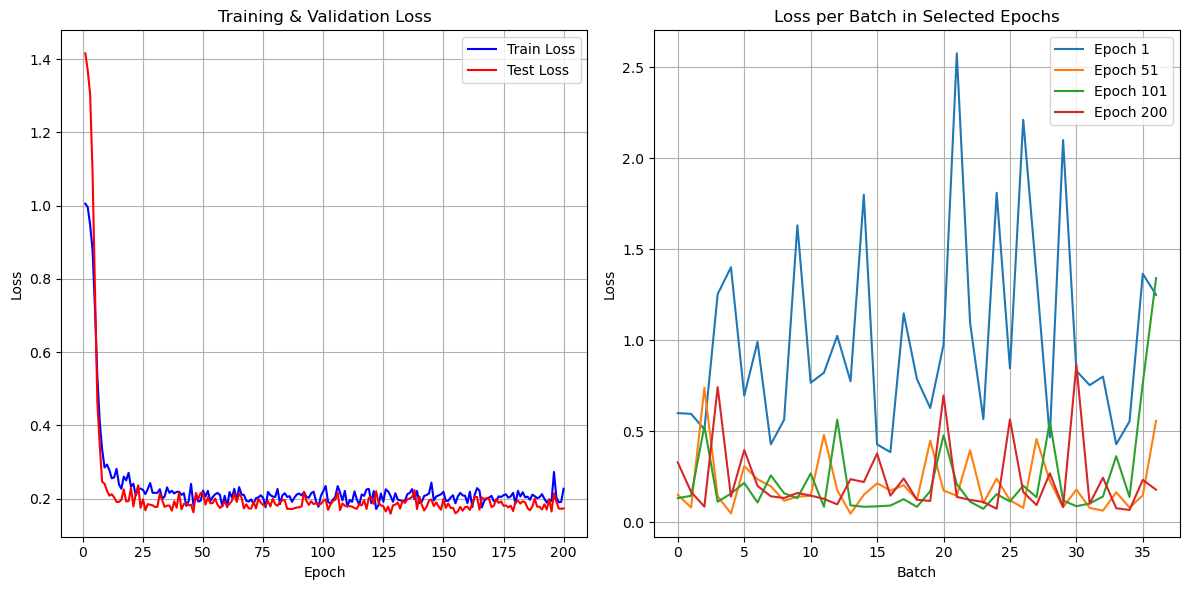

In [11]:
# Vẽ loss theo epoch
plt.figure(figsize=(12, 6))

# Vẽ Train & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch+1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, max_epoch+1), test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for epoch in [0, max_epoch//4, max_epoch//2, max_epoch-1]:  # Chọn vài epoch để hiển thị
    plt.plot(batch_losses[epoch], label=f"Epoch {epoch+1}")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss per Batch in Selected Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
torch.save(model, '../model/model.pth')

In [13]:
filepath = os.path.join('..','data', 'raw', 'test.csv')
data = pd.read_csv(filepath, index_col='Id')

# Loại bỏ cột cuối cùng khỏi danh sách cột xử lý
columns_to_process = data.columns

# Find columns with missing values
lst_of_missing = [col for col in columns_to_process if data[col].isnull().sum() > 0]

# Find numerical and categorical columns
lst_of_numerical = [col for col in columns_to_process if data[col].dtype != 'object']
lst_of_categorical = [col for col in columns_to_process if data[col].dtype == 'object']

# Print information about missing categorical columns
cat_missing = set(lst_of_categorical) & set(lst_of_missing)
print(f'There are {len(cat_missing)} categorical columns with missing values')
for col in cat_missing:
    print(f'{col:<13}: {data[col].isnull().sum(): <4} missing values - {data[col].isnull().sum() / len(data) * 100:.2f}% - {len(data[col].unique())} unique values')

# Save preprocessed data
output_dir = os.path.join('data', 'preprocessed')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'test_preprocessed.csv')
data.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

There are 22 categorical columns with missing values
MSZoning     : 4    missing values - 0.27% - 6 unique values
MasVnrType   : 894  missing values - 61.27% - 4 unique values
Exterior2nd  : 1    missing values - 0.07% - 16 unique values
MiscFeature  : 1408 missing values - 96.50% - 4 unique values
BsmtCond     : 45   missing values - 3.08% - 5 unique values
KitchenQual  : 1    missing values - 0.07% - 5 unique values
BsmtFinType2 : 42   missing values - 2.88% - 7 unique values
PoolQC       : 1456 missing values - 99.79% - 3 unique values
FireplaceQu  : 730  missing values - 50.03% - 6 unique values
BsmtQual     : 44   missing values - 3.02% - 5 unique values
Alley        : 1352 missing values - 92.67% - 3 unique values
GarageType   : 76   missing values - 5.21% - 7 unique values
BsmtExposure : 44   missing values - 3.02% - 5 unique values
GarageQual   : 78   missing values - 5.35% - 5 unique values
Exterior1st  : 1    missing values - 0.07% - 14 unique values
GarageCond   : 78   missi

In [14]:
filepath = './data/preprocessed/test_preprocessed.csv'
data = pd.read_csv(filepath, index_col='Id')

# Fill missing values
data['LotFrontage'] = data['LotFrontage'].fillna(data[data['LotFrontage'] < 300]['LotFrontage'].mean())
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].interpolate())
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

# Fill missing values for categorical columns
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data.drop(['MiscFeature', 'PoolQC', 'Fence', 'Alley'], axis=1, inplace=True)

# Encode categorical columns
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store encoders for potential inverse transform

# Standardize numerical features
scaler = StandardScaler()
data_standardized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Save preprocessed data
output_filepath = './data/preprocessed/test_preprocessed.csv'
data_standardized.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

Preprocessed data saved to ./data/preprocessed/test_preprocessed.csv


In [15]:
# Load preprocessed test data
test_filepath = '../data/preprocessed/test_preprocessed.csv'
test_data = pd.read_csv(test_filepath, index_col='Id')

test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# Load trained model
model_path = '../model/model.pth'
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

# Perform inference
with torch.no_grad():
    test_tensor = test_tensor.to(device)
    predictions = model(test_tensor).cpu().numpy()

# Load scaling parameters
# Load scaling parameters safely
scaling_params_filepath = '../data/preprocessed/scaling_params.txt'

with open(scaling_params_filepath, 'r') as f:
    lines = f.readlines()
    mean = float(lines[0].split()[1])
    std = float(lines[1].split()[1])
        
# Reverse standardization
predictions = predictions * std + mean
predictions = np.nan_to_num(predictions)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [62]:
# Giả sử `test_data` có index là Id
ids = test_data.index  # Lấy cột Id từ dữ liệu test ban đầu

# Tạo DataFrame với 2 cột: Id và SalesPrice
df_predictions = pd.DataFrame({'Id': ids, 'SalePrice': predictions.flatten()})

# Lưu file CSV
output_dir = './data/output'
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'predictions.csv')

df_predictions.to_csv(output_filepath, index=False)

print(f"Predictions saved to {output_filepath}")

Predictions saved to ./data/output/predictions.csv
